In [1]:
# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
import pandas as pd
from datetime import datetime
import re
import nltk
import json
import numpy as np
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob
import contractions 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
import sklearn.tree
import re

%matplotlib inline
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
sns.set(style="darkgrid")

import gensim
from gensim.models import Phrases, KeyedVectors, Word2Vec
import gensim.downloader

from scipy import stats

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/simranbhatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Problem Introduction

We have a dataset in JSON format containing information about the user activity in a reddit forum **ROAP**. Our feature set comes from a bunch of user features noted at the time of posting user comments in the forun alogside the titel and text they chose. The response variable is whether the requester received the pizza or not.

### 1. Loading the training data

In [2]:
with open('data/random-acts-of-pizza/train.json') as f:
    train_json_data = json.load(f)

In [3]:
df = pd.io.json.json_normalize(train_json_data) 
df.head()

<ipython-input-3-41f57f100816>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(train_json_data)


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,False,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09
1,N/A,2,5,False,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09
2,N/A,0,3,False,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,0,1,True,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09


In [4]:
print('Total data rows in full training set: {}'.format(df.shape[0]))
print('Total data columns in full training set: {}'.format(df.shape[1]))

Total data rows in full training set: 4040
Total data columns in full training set: 32


### 2. Splitting training set into training and validation

As we don't have labeled test set, we have to split existing training data into training and validation set in order to evaluate our model performance. We have already split the train and validation in 90/10 ratio and saved as csv files. We read them directly in memory.

In [5]:
# split data in training and test data
train, val = train_test_split(df, test_size=0.1)

In [6]:
print(train.shape)
print(val.shape)

(3636, 32)
(404, 32)


### 3. Extracting relevant columns (which are present in test data) 

In [7]:
relevant_cols = ['request_title', 'request_text_edit_aware' ,
                 'requester_number_of_posts_on_raop_at_request', 
                'requester_number_of_subreddits_at_request', 
                 'unix_timestamp_of_request', 
                'requester_account_age_in_days_at_request',
                'requester_subreddits_at_request',
                'requester_upvotes_minus_downvotes_at_request', 
                'requester_upvotes_plus_downvotes_at_request']

text_cols = ['request_title','request_text_edit_aware']
y_col = 'requester_received_pizza'

In [8]:
train = train[[y_col] + relevant_cols]
val = val[[y_col] + relevant_cols]
train.head()

,requester_received_pizza,request_title,request_text_edit_aware,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,unix_timestamp_of_request,requester_account_age_in_days_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request
929,True,"[REQUEST] New Zealand, hungry artist will tra...",Will draw a little torso sketch of you as a fa...,0,10,1.350023e+09,47.877743,"[AskReddit, Music, WTF, atheism, aww, depressi...",105,205
2852,False,[REQUES] Down and out in need of pizza,"Got roughly $6,000 on 4 cards over the years f...",0,0,1.319931e+09,0.000000,[],0,0
2122,False,[Request] Bellingham WA - starving in a strang...,"I just got into bellingham this morning, tryin...",0,4,1.364878e+09,937.596898,"[AskReddit, DotA2, gaming, todayilearned]",3,31
1615,False,[Request] Parents went out of town for the wee...,Parents went out of town for Memorial Day week...,0,33,1.369599e+09,1038.850463,"[AdviceAnimals, AskReddit, IAmA, ImGoingToHell...",5030,39490
458,False,"[REQUEST] Off of both jobs tonight, just wanti...",Hi! I felt bad making a request but I'm home a...,0,6,1.344042e+09,109.047523,"[AskReddit, DIY, Random_Acts_Of_Amazon, advent...",725,1053


In [9]:
print(train.shape)
print(val.shape)

(3636, 10)
(404, 10)


### 4. Exploration of outcome variable (univariate)

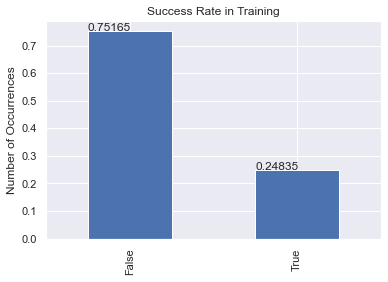

In [10]:
ax = train['requester_received_pizza'].value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 5)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Success Rate in Training')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

We see that there is a **24.5% success rate** in our training set. This is encouraging as although there is a class imbalance in our training dataset, it is not extream. 

### 5. Exploration of non-text features

#### 5.1 requester_number_of_posts_on_raop_at_request

It is evident that most of the requesters in our training set (95.25%) made their first post on RAOP when they requested for pizza. This strongly suggests a novelty effect at play if the training data is representative. When people discover this group and see others requesting pizza, they themselves are encouraged to ask for pizza from an unknown community.

In [11]:
train['requester_number_of_posts_on_raop_at_request'].value_counts()

0    3467
1     126
2      33
3       7
5       2
4       1
Name: requester_number_of_posts_on_raop_at_request, dtype: int64

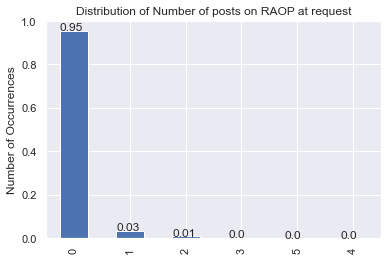

In [12]:
ax = train['requester_number_of_posts_on_raop_at_request'].value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Distribution of Number of posts on RAOP at request')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

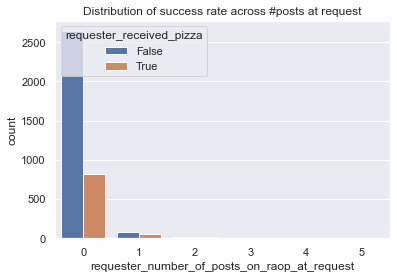

In [13]:
sns.countplot(x = 'requester_number_of_posts_on_raop_at_request', 
              hue='requester_received_pizza', data=train)
plt.title('Distribution of success rate across #posts at request')
pass

#### 5.2 requester_number_of_subreddits_at_request

We see the following pattern 

|Category|sub-reddits|count|Prcnt|
|--|--|--|--|
|New comer|0|656|18.04%|
|Newbie|1-5|730|20.07%|
|Somewhat Engaged|5-10|441|12.12%|
|Medium Engaged|10-50|1510|41.53%|
|Highly Engaged|50-100|267|7.34%|
|Power users|100+|32|0.88%|


This indicates that may be users are finding ROAP via freeform browsing and engaging when needed. Most of the users are existing users of reddit platform. 

In [14]:
pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+']).value_counts(normalize=True)

3. 10-50     0.422717
1. 1-5       0.198295
0. 0         0.183168
2. 5-10      0.115512
4. 50-100    0.072332
5. 100+      0.007976
Name: requester_number_of_subreddits_at_request, dtype: float64

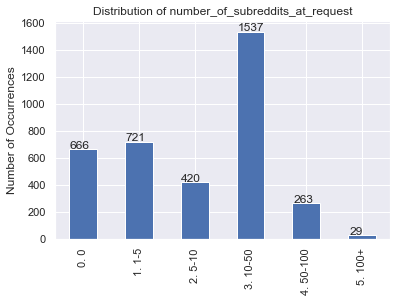

In [15]:
ax = pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+']).value_counts().sort_index().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Distribution of number_of_subreddits_at_request')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

In [16]:
# creating the new feature
feat_train = pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

feat_val = pd.cut(val['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

train['num_subreddits_req'] = feat_train
val['num_subreddits_req'] = feat_val

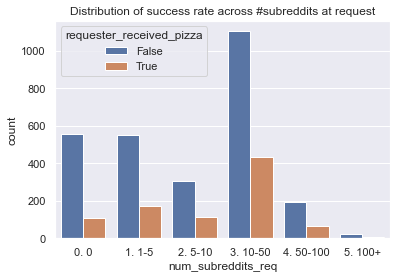

In [17]:
sns.countplot(x = 'num_subreddits_req', hue='requester_received_pizza', data=train)
plt.title('Distribution of success rate across #subreddits at request')
pass

#### 5.3 Unix timestamp of request

In [18]:
# Need to change format of unix timestamp of request, currently it's a float
train['timestamp_converted'] = pd.to_datetime(train['unix_timestamp_of_request'],unit='s')

#### 5.3.1 Distribution by the hour of the day when the request was made

In [19]:
train['hour_bin_4'] = pd.cut(train['timestamp_converted'].dt.hour, 6)
pd.DataFrame(pd.crosstab(train.requester_received_pizza, 
            train.hour_bin_4).apply(lambda r: r/r.sum(), axis=0))

hour_bin_4,"(-0.023, 3.833]","(3.833, 7.667]","(7.667, 11.5]","(11.5, 15.333]","(15.333, 19.167]","(19.167, 23.0]"
requester_received_pizza,,,,,,
False,0.752549,0.801508,0.842105,0.695431,0.706223,0.761452
True,0.247451,0.198492,0.157895,0.304569,0.293777,0.238548


It is seen that different times of the data impact the outcome, with 11 am to 7 pm seeing majority of True requests.

#### 5.3.4 requester_account_age_in_days_at_request

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef8937e310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef8937e9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef89292f70>,
 'medians': [<matplotlib.lines.Line2D at 0x7fef8938c0d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fef8938c3d0>,
 'means': []}

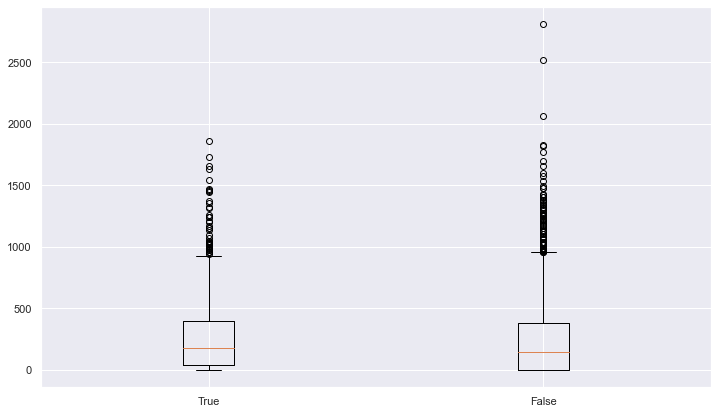

In [20]:
requester_account_age_in_days_at_request_1 = train[train['requester_received_pizza'] == True]['requester_account_age_in_days_at_request']
requester_account_age_in_days_at_request_0 = train[train['requester_received_pizza'] == False]['requester_account_age_in_days_at_request']

set_to_plot = [requester_account_age_in_days_at_request_1, requester_account_age_in_days_at_request_0]

labels = train['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)


The difference in distribution seems more than the other features analyzed below.

#### 5.3.6 requester_subreddits_at_request

In [21]:
requester_subreddits_at_request_1 = train[train['requester_received_pizza'] == True]['requester_subreddits_at_request']
requester_subreddits_at_request_0 = train[train['requester_received_pizza'] == False]['requester_subreddits_at_request']
requester_subreddits_at_request_0


2852                                                   []
2122            [AskReddit, DotA2, gaming, todayilearned]
1615    [AdviceAnimals, AskReddit, IAmA, ImGoingToHell...
458     [AskReddit, DIY, Random_Acts_Of_Amazon, advent...
1129    [Android, AndroidQuestions, AskReddit, DoesAny...
                              ...                        
2533                                                   []
1271    [AdviceAnimals, Art, AskReddit, Coachella, Dis...
3269                                                   []
1817    [AdviceAnimals, AskReddit, Berserk, BitCard, B...
66      [4chan, AskReddit, Autos, DoesAnybodyElse, Fav...
Name: requester_subreddits_at_request, Length: 2733, dtype: object

##### 5.3.6.1 Relationship between number of subreddits with activity and altruism

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef893f3370>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef893f3a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef893e5fd0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fef893fe130>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fef893fe430>,
 'means': []}

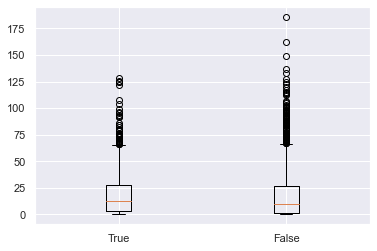

In [22]:
len_requester_subreddits_at_request_1 = []
for r1 in requester_subreddits_at_request_1:
    len_requester_subreddits_at_request_1.append(len(r1))
    
len_requester_subreddits_at_request_0 = []
for r0 in requester_subreddits_at_request_0:
    len_requester_subreddits_at_request_0.append(len(r0))

set_to_plot = [len_requester_subreddits_at_request_1, len_requester_subreddits_at_request_0]

labels = train['requester_received_pizza'].unique()

plt.boxplot(set_to_plot, labels=labels)

Those with fulfilled pizza requests seem to be (on average) lesser active in subreddits than those with unfulfilled requests.

##### 5.3.6.2 Relationship between number of "Random" subreddits with activity and altruism

Analyzing activity in the following subreddits:

In [23]:
def find_subreddits(data, to_look_for):
    found_subreddits = []
    for subreddits in data:
        splits_by_line = subreddits.replace(']','').replace('[','').split('\n')
        splits_subreddits = [s.replace("'","").split(",") for s in splits_by_line]
        found_subreddits.append([r for r in splits_subreddits[0] if to_look_for.lower() in r.lower()])
    return found_subreddits

find_subreddits(train['requester_subreddits_at_request'],"Random")

AttributeError: 'list' object has no attribute 'replace'

In [24]:
[len(f) for f in find_subreddits(train['requester_subreddits_at_request'],"Random")]

AttributeError: 'list' object has no attribute 'replace'

In [25]:
len_random_requester_subreddits_at_request_1 = []
len_random_requester_subreddits_at_request_1.append(
    [len(f) for f in find_subreddits(requester_subreddits_at_request_1,"Random")])
print(np.mean(len_random_requester_subreddits_at_request_1))

len_random_requester_subreddits_at_request_0 = []
len_random_requester_subreddits_at_request_0.append(
    [len(f) for f in find_subreddits(requester_subreddits_at_request_0,"Random")])
print(np.mean(len_random_requester_subreddits_at_request_0))   

AttributeError: 'list' object has no attribute 'replace'

##### 5.3.6.3 Relationship between activity in "Random_Acts_Of_Pizza" subreddits and altruism

In [26]:
len_random_requester_subreddits_at_request_1 = []
len_random_requester_subreddits_at_request_1.append(
    [len(f) for f in find_subreddits(requester_subreddits_at_request_1,"Random_Acts_Of_Pizza")])
print(np.mean(len_random_requester_subreddits_at_request_1))

len_random_requester_subreddits_at_request_0 = []
len_random_requester_subreddits_at_request_0.append(
    [len(f) for f in find_subreddits(requester_subreddits_at_request_0,"Random_Acts_Of_Pizza")])
print(np.mean(len_random_requester_subreddits_at_request_0))   

AttributeError: 'list' object has no attribute 'replace'

##### 5.3.6.4 Relationship between activity in 'Food' related subreddits and altruism

In [27]:
len_random_requester_subreddits_at_request_1 = []
len_random_requester_subreddits_at_request_1.append(
    [len(f) for f in find_subreddits(requester_subreddits_at_request_1,"food")])
print(np.mean(len_random_requester_subreddits_at_request_1))

len_random_requester_subreddits_at_request_0 = []
len_random_requester_subreddits_at_request_0.append(
    [len(f) for f in find_subreddits(requester_subreddits_at_request_0,"food")])
print(np.mean(len_random_requester_subreddits_at_request_0))   

AttributeError: 'list' object has no attribute 'replace'

##### What types of subreddits are most commonly associated with pizza request fulfilment

In [28]:
subreddits_frequency = {}
for r1 in requester_subreddits_at_request_1:
    for s in r1.replace('[','').replace(']','').split(','):
        subreddit = s.replace("'","").replace(" ","")
        if subreddit in list(subreddits_frequency.keys()):
            subreddits_frequency[subreddit] = subreddits_frequency[subreddit]+1
        else:
            subreddits_frequency[subreddit] = 1

sorted_subreddits_frequency = sorted(subreddits_frequency.items(), key=lambda item: item[1], reverse = True)

print(sorted_subreddits_frequency[0:5]) 

AttributeError: 'list' object has no attribute 'replace'

#### 5.4 requester_upvotes_minus_downvotes_at_request

1351.2403100775193
1088.2414928649835


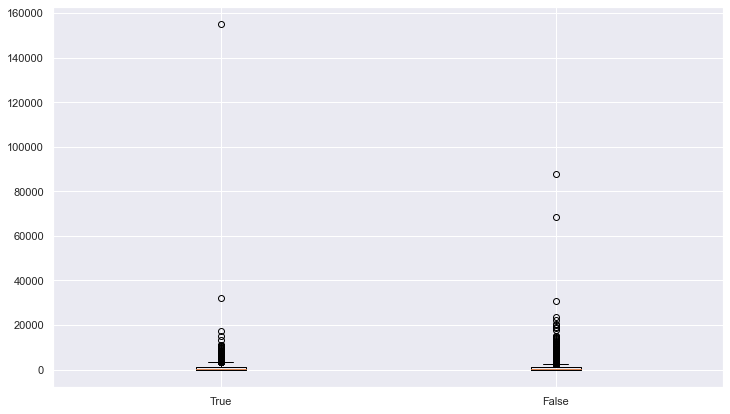

In [29]:
requester_upvotes_minus_downvotes_at_request_1 = train[train['requester_received_pizza'] == True]['requester_upvotes_minus_downvotes_at_request']
requester_upvotes_minus_downvotes_at_request_0 = train[train['requester_received_pizza'] == False]['requester_upvotes_minus_downvotes_at_request']

set_to_plot = [requester_upvotes_minus_downvotes_at_request_1, requester_upvotes_minus_downvotes_at_request_0]

labels = train['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)

print(np.mean(requester_upvotes_minus_downvotes_at_request_1))
print(np.mean(requester_upvotes_minus_downvotes_at_request_0))

In [32]:
requester_upvotes_minus_downvotes_at_request_1 = train[train['requester_received_pizza'] == True]['requester_upvotes_minus_downvotes_at_request']
requester_upvotes_minus_downvotes_at_request_0 = train[train['requester_received_pizza'] == False]['requester_upvotes_minus_downvotes_at_request']
print(len(requester_upvotes_minus_downvotes_at_request_1))
#removing outliers
z = np.abs(stats.zscore(requester_upvotes_minus_downvotes_at_request_1))
#print(z)
requester_upvotes_minus_downvotes_at_request_1_removed_outliers = requester_upvotes_minus_downvotes_at_request_1.where(z < 2)
print(len(requester_upvotes_minus_downvotes_at_request_1_removed_outliers))

print(len(requester_upvotes_minus_downvotes_at_request_0))
#removing outliers
z = np.abs(stats.zscore(requester_upvotes_minus_downvotes_at_request_0))
#print(z)
requester_upvotes_minus_downvotes_at_request_0_removed_outliers = requester_upvotes_minus_downvotes_at_request_0.where(z < 2)
print(len(requester_upvotes_minus_downvotes_at_request_0_removed_outliers))

903
903
2733
2733


#### 5.5 requester_upvotes_plus_downvotes_at_request

4858.928017718716
3349.279180387852


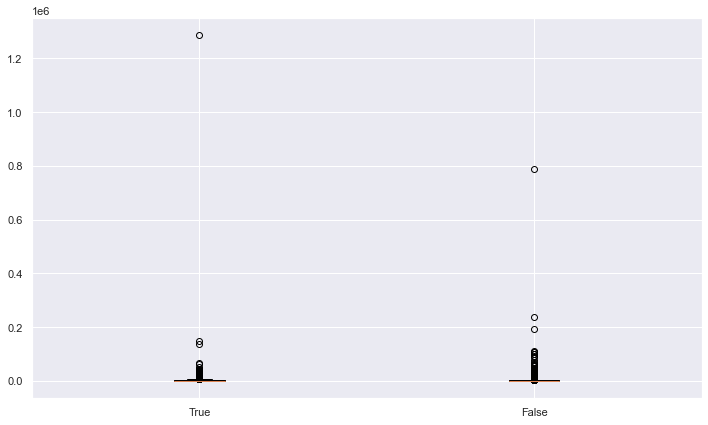

In [33]:
requester_upvotes_plus_downvotes_at_request_1 = train[train['requester_received_pizza'] == True]['requester_upvotes_plus_downvotes_at_request']
requester_upvotes_plus_downvotes_at_request_0 = train[train['requester_received_pizza'] == False]['requester_upvotes_plus_downvotes_at_request']

set_to_plot = [requester_upvotes_plus_downvotes_at_request_1, requester_upvotes_plus_downvotes_at_request_0]

labels = train['requester_received_pizza'].unique()

fig, ax = plt.subplots(figsize=(12, 7))
ax.boxplot(set_to_plot, labels=labels)

print(np.mean(requester_upvotes_plus_downvotes_at_request_1))
print(np.mean(requester_upvotes_plus_downvotes_at_request_0))

#### 5.6 PCA for request (excluding text) features analyzed or created above

Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

It helps extract information from features that is not shared between them so we are not weighing some information more than other because it is contained in a large portion of our selected feautres. 

PCA outputs a set of features (that are independent of one another/orthogonal in the dimensionality space). These are hard to interpret but they hold the information from the variables that we give as input to PCA.  

In [34]:
len_subreddits = []
random_subreddits = []
random_pizza_subreddits = []
food_subreddits = []

request_meta_features = train[['requester_account_age_in_days_at_request',
                         'requester_subreddits_at_request',
                         'requester_upvotes_minus_downvotes_at_request',
                         'requester_upvotes_plus_downvotes_at_request',]]


for i,requests in enumerate(request_meta_features['requester_subreddits_at_request']):
    request_meta_features.loc[i,'len_subreddits'] = len(requests)
    request_meta_features.loc[i,'random_subreddits'] = len([r for r in requests if "random" in r.lower()])
    request_meta_features.loc[i,'random_pizza_subreddits'] = len([r for r in requests if "random acts of pizza" in r.lower()])
    request_meta_features.loc[i,'food_subreddits'] = len([r for r in requests if "food" in r.lower()])
    request_meta_features.loc[i,'common_subreddits'] = len([r for r in requests if 
                                                            (sorted_subreddits_frequency[0][0] in r.lower()
                                                            or sorted_subreddits_frequency[1][0] in r.lower()
                                                            or sorted_subreddits_frequency[2][0] in r.lower()
                                                            or sorted_subreddits_frequency[3][0] in r.lower()
                                                            or sorted_subreddits_frequency[4][0] in r.lower())])


pca_features = sklearn.decomposition.PCA(request_meta_features)

print(pca_features)

/Users/simranbhatia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/simranbhatia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


NameError: name 'sorted_subreddits_frequency' is not defined

### 6. Exploration of text-based features

### 6.1 Basic Analysis of text field

In [35]:
request_text_features = train[['request_text_edit_aware']]
request_labels = train[['requester_received_pizza']]
request_text_features.head()

,request_text_edit_aware
929,Will draw a little torso sketch of you as a fa...
2852,"Got roughly $6,000 on 4 cards over the years f..."
2122,"I just got into bellingham this morning, tryin..."
1615,Parents went out of town for Memorial Day week...
458,Hi! I felt bad making a request but I'm home a...


In [36]:
# separating train data by topics for analysis
completed_request_indices = [i for i,l in enumerate(request_labels['requester_received_pizza']) if l==True]
not_completed_request_indices = [i for i,l in enumerate(request_labels['requester_received_pizza']) if l==False]


completed_request_train_data = [t for i,t in enumerate(request_text_features['request_text_edit_aware']) if i in completed_request_indices]
not_completed_request_train_data = [t for i,t in enumerate(request_text_features['request_text_edit_aware']) if i in not_completed_request_indices]


In [37]:
print("lengths for pizza request completed: ",
      np.mean([len(x) for x in completed_request_train_data]))
print("lengths for pizza request not completed: ",
      np.mean([len(x) for x in not_completed_request_train_data]))

lengths for pizza request completed:  472.3709856035437
lengths for pizza request not completed:  375.05488474204174


In [38]:
np.std([len(x) for x in request_text_features['request_text_edit_aware']])

366.48059284853906

In [39]:
def lengths_feature(data):
    
    lengths = [len(x) for x in data]
    
    return np.reshape(np.array(lengths),( len(lengths), 1 ))

print("number of words for pizza request completed: ",
      np.mean([len(x.split())for x in completed_request_train_data]))
print("number of words request not completed: ",
      np.mean([len(x.split()) for x in not_completed_request_train_data]))

number of words for pizza request completed:  90.28682170542636
number of words request not completed:  72.01719721917307


In [40]:
def num_words_feature(data):
        
    words = [len(x.split()) for x in data]
        
    return np.reshape(np.array(words),( len(words), 1 ))

print("number of capital letters for pizza request completed: ",
      np.mean([sum(1 for c in x.split() if c.isupper()) for x in completed_request_train_data]))
print("number of capital letters request not completed: ",
      np.mean([sum(1 for c in x.split() if c.isupper()) for x in not_completed_request_train_data]))

number of capital letters for pizza request completed:  4.040974529346622
number of capital letters request not completed:  3.2590559824368825


In [41]:
np.std([sum(1 for c in x.split() if c.isupper()) for x in request_text_features['request_text_edit_aware']])

4.65725865984963

In [42]:
def num_caps_feature(data):
    
    caps = [sum(1 for c in x.split() if c.isupper()) for x in data]
        
    return np.reshape(np.array(caps),(len(caps), 1))

print("number of capital letters/length for pizza request completed: ",
      np.mean([sum(1 for c in x.split() if c.isupper())/len(x) if len(x)>0 else 0 for x in completed_request_train_data]))
print("number of capital letters/length request not completed: ",
      np.mean([sum(1 for c in x.split() if c.isupper())/len(x) if len(x)>0 else 0  for x in not_completed_request_train_data]))

number of capital letters/length for pizza request completed:  0.008576704992833573
number of capital letters/length request not completed:  0.008440469298842783


In [43]:
def caps_vs_lengths_feature(data):
    
    caps_vs_lengths = [sum(1 for c in x.split() if c.isupper())/len(x) if len(x)>0 else 0 for x in data]
    
    return np.reshape(np.array(caps_vs_lengths),(len(caps_vs_lengths), 1))

print("number of unique words for pizza request completed: ",
      np.mean([len(set(w for w in x.split())) for x in completed_request_train_data]))
print("number of unique words request not completed: ",
      np.mean([len(set(w for w in x.split())) for x in not_completed_request_train_data]))

number of unique words for pizza request completed:  67.76744186046511
number of unique words request not completed:  55.46652030735456


In [46]:
def num_unique_words_feature(data):
    
    num_unique_words = [len(set(w for w in x.split())) for x in data]

    return np.reshape(np.array(num_unique_words),(len(num_unique_words), 1))

In [50]:
puncs = '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`'
def num_punctuations_feature(data):
    
    num_punctuations = [sum(x.count(w) for w in puncs) for x in data]
        
    return np.reshape(np.array(num_punctuations),(len(num_punctuations), 1))

print("number of punctuations for pizza request completed: ",
      np.mean([sum(x.count(w) for w in puncs) for x in completed_request_train_data]))
print("number of punctuations request not completed: ",
      np.mean([sum(x.count(w) for w in puncs) for x in not_completed_request_train_data]))

number of punctuations for pizza request completed:  16.940199335548172
number of punctuations request not completed:  13.056714233443103


In [51]:
np.std([sum(x.count(w) for w in puncs) for x in request_text_features['request_text_edit_aware']])

14.30270895050531

In [52]:
def num_stopwords_feature(data):
    
    num_stopwords = [sum(x.count(w) for w in set(nltk.corpus.stopwords.words('english'))) for x in data]
        
    return np.reshape(np.array(num_stopwords),(len(num_stopwords), 1))

print("number of stop words for pizza request completed: ",
      np.mean([sum(x.count(w) for w in set(nltk.corpus.stopwords.words('english'))) for x in completed_request_train_data]))
print("number of stop words request not completed: ",
      np.mean([sum(x.count(w) for w in set(nltk.corpus.stopwords.words('english'))) for x in not_completed_request_train_data]))

number of stop words for pizza request completed:  265.5913621262458
number of stop words request not completed:  211.10647639956093


In [53]:
url_regex = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")

completed_requests_with_url = 0
not_completed_request_with_url = 0

for x in completed_request_train_data:
    url_regex_found = [f[0] for f in re.findall(url_regex,str(x))]
    if(len(url_regex_found)>0):
        completed_requests_with_url += 1

for x in not_completed_request_train_data:
    url_regex_found = [f[0] for f in re.findall(url_regex,str(x))]
    if len(url_regex_found)>0:
        not_completed_request_with_url += 1

print("average number of completed request containing a URL:",
      completed_requests_with_url*1.0/len(completed_request_train_data))
print("average number of not completed request containing a URL:",
      not_completed_request_with_url*1.0/len(not_completed_request_train_data))

average number of completed request containing a URL: 0.10299003322259136
average number of not completed request containing a URL: 0.06147091108671789


In [54]:
def requests_with_url(data):
    
    requests_with_url = [1 if len([f[0] for f in re.findall(url_regex,str(x))])>0 else 0 for x in data]
        
    return np.reshape(np.array(requests_with_url),(len(requests_with_url), 1))

In [55]:
np.mean(requests_with_url(completed_request_train_data))

0.10299003322259136

In [56]:
np.mean(requests_with_url(not_completed_request_train_data))

0.06147091108671789

### 6.2 Feature Preprocessing 

The first step for text processing is to set up the preprocessing functions. In our preprocessing steps, we are doing the following:

1. Coverting the text to lower case
2. Removing stopwords
3. Removing digits
4. Lemmatizing the word tokens

### 6.2.1 Creating stopword list

Added a couple of custom stopwords that are frequently used in ROAP requests (e.g. piza, request, hey, hi)

In [57]:
# stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
# adding some of our own stop words to NLTK's stopword list
stopwords_nltk_en = set(stopwords.words('english') + ['though','pizza', 'request', 'hey', 'hi'])
# create stop word list for punctuation
stopwords_punct = set(punctuation)
# combine the three stopwords lists
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

### 6.2.2 Create Text Pre-processor
Added the ability to replace contractions with their proper form and remove URLS to the text preprocessor

In [58]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text_1(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    # added functions to replace contractions with their proper form
    # and remove any URLs
    processed_list = [word for word in lemmatize_sent(contractions.fix(re.sub(r'http\S+', '', text)))
            if word not in stoplist_combined
            and not word.isdigit()]
    processed_text = ' '.join(processed_list) 
    return processed_text


def preprocess_text_2(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return ' '.join([word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()])

### 6.3 Using TFIDFVectorizer for Bigrams

In [59]:
# Initialize bigram TDIFD vectorizer 
tf_bigram = TfidfVectorizer(analyzer = 'word', preprocessor = preprocess_text_1, ngram_range = (2, 2))
train_bigram = tf_bigram.fit_transform(train['request_text_edit_aware'])

# average frequency of ngrams
avg_values = train_bigram.toarray().sum(axis=0)
# list of ngrams
vocab = tf_bigram.vocabulary_
df_bigram = pd.DataFrame(sorted([(avg_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'sum frequency', 1:'bigram'})

In [60]:
df_bigram[:20]

,sum frequency,bigram
0,40.771764,pay forward
1,17.831264,college student
2,15.412475,return favor
3,15.410980,sob story
4,13.989663,bank account
5,13.361998,lose job
6,11.078374,papa john
7,10.608835,pay back
8,9.410354,couple day
9,9.290891,pay week


### 6.4 Topic Modeling using LDA (Latent Dirichlet Allocation)

After using the TDIDF vectorizer to create bigrams, we looked into whether similar bigrams can be grouped into topics. One method we used for topic modeling is LDA.

LDA is an iterative probabilistic model that creates topics using two probability values: P(Word|Topic) and P(Topic|Document). We set the LDA model tocreate 10 topics. First, LDA will randomly assign bigrams to 10 topics. Then it'll use the two probability values to reassign bigrams to topics. The reassignment step will happen over and over again until the model converges. This results is the final 10 topics.

In [61]:
# topics for TFIDF trigrams using LDA
lda = LatentDirichletAllocation(n_components=10)
pipe_lda = make_pipeline(tf_bigram, lda)
pipe_lda.fit(train['request_text_edit_aware'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, papa john, sob story, college student, bank account
Topic #1: pay forward, sob story, college student, pay rent, lose job
Topic #2: pay forward, poor college, bank account, college student, lose job
Topic #3: pay forward, random act, money food, food money, sob story
Topic #4: pay forward, pay back, return favor, lose job, sob story
Topic #5: pay forward, return favor, week ago, paycheck paycheck, hard time
Topic #6: pay forward, bank account, college student, sob story, lose job
Topic #7: pay forward, college student, bank account, pay week, sob story
Topic #8: pay forward, college student, pay week, return favor, pay friday
Topic #9: pay forward, return favor, college student, bank account, run food



### 6.5 Topic Modeling using NMF (Non-negative Matrix Factorization)

Another topic modeling method we used was NMF. NMF is a linear algebreic model that moves from higher dimensionality to lower dimensionality. It makes a given document-word matrix (our TDIDF matrix) and factors it into two lower dimensional forms: one is a vector of topics and another is a matrix of topic weights for each document. The two lower dimensionality forms are calculated by iterating over them until them optimize and coverge.

Below we used NMF to create 10 topics like we did above with LDA modeling. From NMF we saw topics that seemed to make more sense and have less repetition.

In [62]:
## topics for TFIDF trigrams using NMF
nmf = NMF(n_components=10)
pipe = make_pipeline(tf_bigram, nmf)
pipe.fit(train['request_text_edit_aware'])
print_top_words(nmf, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, promise pay, forward money, forward feel, forward friday
Topic #1: college student, broke college, poor college, student pay, break college
Topic #2: return favor, gladly return, love return, favor paycheck, favor pay
Topic #3: sob story, story hungry, title pretty, pretty sob, hungry bore
Topic #4: lose job, job week, week ago, job month, month ago
Topic #5: pay week, week pay, week buy, forward pay, reciprocate pay
Topic #6: pay back, pay friday, pay day, day pay, love pay
Topic #7: bank account, account information, cent bank, past week, transfer bank
Topic #8: papa john, gift card, domino hut, full time, domino papa
Topic #9: money food, food eat, eat today, food hungry, hungry nice



In [63]:
## topics for TFIDF trigrams using NMF for those who did get pizza
nmf = NMF(n_components=10)
pipe = make_pipeline(tf_bigram, nmf)
pipe.fit(train.request_text_edit_aware[train.requester_received_pizza == True])
print_top_words(nmf, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, forward money, forward feel, promise pay, grateful pay
Topic #1: couple day, job pay, work week, past couple, pay work
Topic #2: college student, poor college, make friday, friday random, random college
Topic #3: pay week, reciprocate pay, house mood, egg leave, cereal egg
Topic #4: sob story, money food, hungry nice, food hungry, find heart
Topic #5: return favor, love return, pay friday, day pay, fee day
Topic #6: bank account, empty bank, pay bank, dollar bank, account pay
Topic #7: day love, eat day, meal day, love eat, love nice
Topic #8: make day, lose job, job week, week ago, bad day
Topic #9: pay back, back pay, back forward, north carolina, gladly pay



/Users/simranbhatia/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [64]:
## topics for TFIDF trigrams using NMF for those who did not get piza
nmf = NMF(n_components=10)
pipe = make_pipeline(tf_bigram, nmf)
pipe.fit(train.request_text_edit_aware[train.requester_received_pizza == False])
print_top_words(nmf, tf_bigram.get_feature_names(), n_top_words=5)

Topic #0: pay forward, promise pay, advance pay, throw pay, forward paycheck
Topic #1: college student, broke college, student pay, break college, poor college
Topic #2: return favor, gladly return, favor paycheck, title return, assuredly return
Topic #3: sob story, story hungry, hungry bore, random act, story random
Topic #4: lose job, job month, job couple, job week, month ago
Topic #5: pay back, pay week, forward pay, pay friday, week pay
Topic #6: pay day, couple day, food money, make day, money buy
Topic #7: bank account, account information, cent bank, past week, transfer bank
Topic #8: money food, food eat, eat today, starve money, food reach
Topic #9: papa john, gift card, domino hut, full time, alfys papa



### 6.6 PMI Calculation
The idea of PMI is that we want to quantify the likelihood of co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. Hence, the algorithm computes the (log) probability of co-occurrence scaled by the product of the single probability of occurrence as follows:


$$
PMI (a, b) = \log(\frac{P(a, b)}{P(a) * P(b)})
$$

Now, knowing that, when ‘a’ and ‘b’ are independent, their joint probability is equal to the product of their marginal probabilities, when the ratio equals 1 (hence the log equals 0), it means that the two words together don’t form a unique concept: they co-occur by chance.

It is important to note that we can use PMI criterion to not just detect the collocation of two words. We can also use it to get a sense of if a word and a class are co-occuring togather or not. This is the way we are going to use PMI in our case. 

#### 6.6.1 Counting inclass and overall frequencies for all words in training dataset

The next step is to start with the pre-processed text and identify the occurance frequency for each token in the training and test dataset. 

In [65]:
def count_words_per_category(v, out):
    result_true, result_false, result_vocab = {}, {}, {}
    for ind, line in enumerate(v):
        #print(ind)
        #print(out[ind])
        trf_line = preprocess_text_2(line) # preprocess and lammatized title text
        for elem in trf_line:
            result_vocab[elem] = result_vocab.get(elem, 0) + 1
            
            if out[ind]:
                result_true[elem] = result_true.get(elem, 0) + 1
            else: 
                result_false[elem] = result_false.get(elem, 0) + 1
    
    return result_true, result_false, result_vocab

#### 6.6.2 Implementing the PMI function

In the next step, we implement the PMI function and compute PMI for all the words in the dictionary

In [66]:
def pmi(inclass_freq, total_freq, class_freq, min_count=10):
    """
    inclass_freq (dict): dictionary containing inclass frequency for a given word
    total_freq (dict): dictionary containing total frequency for a given word
    class_freq (float): class prevalence
    min_count (int): minimum frequency for pmi calculation
    """
    pmi = {}
    for word, freq in total_freq.items():
        if freq < min_count:
            continue
        pmi[word] = np.log((inclass_freq.get(word, 0) + 0.001) * 1.0 / (class_freq * freq))
    return pmi

### 7. Feature Engineering

#### 7.1 non-text features

Looking at the data, there are just few text fields and a lot of non-text features present. We start with creating the non-text features first and then add text based features on top. 

In [67]:
# feature 1 - number of posts on ROAP at request

def num_posts_roap(data, colname, id_colname,th=0):
    """
    data (pandas dataframe): inout data frame
    colname (str): original column name
    id_colname (str): identifier for the created feature
    th (int): threshold for creating binary feature
    """
    new_colname = id_colname + '_' +colname
    feat = np.where(data[colname] == th, 0, 1)
    data[new_colname] = feat
    del data[colname]
    return data

In [68]:
# feature 2 - number subreddits dummy variables

def num_subreddit_dummy(data, colname):
    """
    data (pandas dataframe): inout data frame
    colname (str): original column name
    """
    return pd.get_dummies(data=data, columns=[colname], drop_first=True)

In [69]:
train_final = train.copy()
val_final = val.copy()

In [70]:
train_final = num_posts_roap(data=train_final, 
                             colname='requester_number_of_posts_on_raop_at_request', 
                             id_colname='binary')

val_final = num_posts_roap(data=val_final, 
                             colname='requester_number_of_posts_on_raop_at_request', 
                             id_colname='binary')

In [71]:
train_final = num_subreddit_dummy(data = train_final, colname= 'num_subreddits_req')
val_final = num_subreddit_dummy(data = val_final, colname= 'num_subreddits_req')

In [72]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+'],
      dtype='object')

#### 7.2 Text feature extraction

We start by extacting the top 20 words from both text and title columns w.r.t. PMI criterion. For that we need to calculate the inclass frequencies and compute PMI as noted in above code. 

In [73]:
def get_counts(data, text_colname, outcome_colname):
    return count_words_per_category(data[text_colname], 
                                    list(data[outcome_colname]))

def get_top_k_from_dict(d, k):
    return sorted(d.items(), key=lambda kv: kv[1])[-k:]

def get_words(sorted_dict):
    return [w[0] for w in sorted_dict]

def calculate_pmi(data, text_colname, outcome_colname, class_freq_true, top_k):
    count_class_true, count_class_false, count_total = get_counts(data = data, 
                                                         text_colname=text_colname, 
                                                         outcome_colname=outcome_colname) 
    pmi_true = pmi(inclass_freq=count_class_true, 
                   total_freq=count_total, 
                   class_freq=class_freq_true)
    
    pmi_false = pmi(inclass_freq=count_class_false, 
                   total_freq=count_total, 
                   class_freq=1-class_freq_true)
    
    pmi_true_top_k = get_top_k_from_dict(pmi_true, k=top_k)
    pmi_false_top_k = get_top_k_from_dict(pmi_false, k=top_k)
    
    pmi_true_words = get_words(pmi_true_top_k)
    pmi_false_words = get_words(pmi_false_top_k)
    
    return pmi_true_words, pmi_false_words


In [74]:
true_class_pmi_words_title, false_class_pmi_words_title = calculate_pmi(data = train_final, 
                                                                        text_colname='request_title', 
                                                                        outcome_colname='requester_received_pizza', 
                                                                        class_freq_true=0.24505, 
                                                                        top_k=20)

In [75]:
true_class_pmi_words_text, false_class_pmi_words_text = calculate_pmi(data = train_final, 
                                                                      text_colname='request_text_edit_aware', 
                                                                      outcome_colname='requester_received_pizza', 
                                                                      class_freq_true=0.24505, 
                                                                      top_k=20)

In [76]:
# Creating text features - token counts
def simple_token_count(v):
    result = []
    for line in v:
        if line != line:
            result.append(1)
            continue
        result.append(len(word_tokenize(line)))
    return result

In [77]:
title_length_train = simple_token_count(train_final.request_title)
title_length_val = simple_token_count(val_final.request_title)
text_length_train = simple_token_count(train_final.request_text_edit_aware)
text_length_val = simple_token_count(val_final.request_text_edit_aware)

In [78]:
train_final['title_length'] = title_length_train
train_final['text_length'] = text_length_train
val_final['title_length'] = title_length_val
val_final['text_length'] = text_length_val

In [79]:
train_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'timestamp_converted',
       'hour_bin_4', 'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+', 'title_length', 'text_length'],
      dtype='object')

In [80]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'unix_timestamp_of_request', 'requester_account_age_in_days_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+', 'title_length', 'text_length'],
      dtype='object')

In [82]:
## Advanced word matching features

w_vect = gensim.downloader.load('glove-twitter-50')

In [83]:
def get_binary_feature(word, vector, wv):
    result = []
    candidates = set([w[0] for w in wv.most_similar(word, topn=20)] + [word])
    for line in vector:
        if line != line:
            result.append(0)
            continue
        trf_line = preprocess_text_2(line)
        if len(candidates.intersection(set(trf_line))) > 0:
            result.append(1)
        else:
            result.append(0)
    return result

def text_feature_addition(word_list, df, colname, id_str, wv):
    for ind, word in enumerate(word_list):
        print(ind, ' : ', word)
        f_name = id_str + word
        feat = get_binary_feature(word, df[colname], wv)
        df[f_name] = feat
    return df

In [84]:
train_final = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=train_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

train_final = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=train_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

train_final = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=train_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

train_final = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=train_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  m
1  :  x
2  :  h
3  :  t
4  :  s
5  :  w
6  :  g
7  :  f
8  :  n
9  :  l
10  :  r
11  :  e
12  :  q


KeyboardInterrupt: 

In [ ]:
val_final = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=val_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

val_final = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=val_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

val_final = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=val_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

val_final = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=val_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

In [ ]:
train_final.columns

In [ ]:
val_final.columns

### 8. Model training and baseline results

In [ ]:
Xcols = [c for c in train_final.columns.tolist() if c not in train.columns.tolist()[:3]]

#### 8.1 Hyper parameter tuning

In [ ]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(1, 10, 1)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'log2', 8, 10, 15, 20]

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(4, 10, 7)]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

rf_class_weight = [None, 'balanced', 'balanced_subsample']

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
            'max_depth': rf_max_depth,
            'max_features': rf_max_features,
            'min_samples_split': rf_min_samples_split,
            'bootstrap': rf_bootstrap, 
            'class_weight': rf_class_weight}

rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 2000, cv = 5, verbose = 1, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(train_final[Xcols], train_final[y_col])

# View the best parameters from the random search
rf_random.best_params_

#### 8.2 Final model fitting 

In [ ]:
rf_final = RandomForestClassifier(n_estimators=400, min_samples_split=8, max_features=20, 
                                  max_depth=1, class_weight=None,
                                 bootstrap=True, n_jobs=-1, random_state=42)

rf_final.fit(train_final[Xcols], train_final[y_col])

#### 8.3 Model predictions

In [ ]:
prediction_probs = rf_final.predict_proba(val_final[Xcols])[:,1]

In [ ]:
feat_importances = pd.Series(rf_final.feature_importances_, index=Xcols)
feat_importances.nlargest(10).plot(kind='barh')
pass

#### 8.4 Choosing right thresholds and reporting results

In [ ]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(val_final[y_col], prediction_probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = 0.24505
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
pred_label = prediction_probs>=0.239164

In [ ]:
print(classification_report(y_true=val_final[y_col], y_pred=pred_label))